### Brain Age Prediction using Deep Neural Network with TensorFlow

In [1]:
import numpy as np
import random as rn
import pandas as pd

from plotnine import * 

# for reproducibility results:
np.random.seed(42)

import tensorflow as tf
from keras import backend as K
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
# from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras import optimizers
from keras import regularizers

import matplotlib.pyplot as plt
#from keras.callbacks import TensorBoard
import time

from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data
dat = np.load('./full_reduced/full/feaDAT.npy')
age = np.load('./full_reduced/full/ageDAT.npy')
sex = np.load('./full_reduced/full/sexDAT.npy')

In [3]:
# preprocess data
X = preprocessing.scale(dat)

In [7]:
X.shape

(2026, 5124)

In [5]:
#Splitting into Training set and Test set, X, Y pair
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, age, test_size = 0.2, random_state = 42)

In [71]:
#model setup
N = 50;
actfun = 'tanh' # 'relu'
def create_model():
    model = Sequential()
    model.add(Dense(N, input_dim=X.shape[1], kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), 
                    activation = 'tanh'))
    model.add(Dropout(0.50))
    model.add(Dense(N, kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), 
                    activation= 'tanh'))
    model.add(Dropout(0.50))
    model.add(Dense(N, kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), 
                    activation= 'tanh'))
    model.add(Dropout(0.50))
    model.add(Dense(N, kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), 
                    activation= 'tanh')) 
    model.add(Dropout(0.50))
    model.add(Dense(N, kernel_initializer='normal', 
                    kernel_regularizer=regularizers.l2(0.01), 
                    activation= 'tanh'))
    
    model.add(Dropout(0.50))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
              
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn = create_model, epochs=1000, batch_size=100, verbose=0, shuffle=True)


In [72]:
t0 = time.time()
baseline_history = estimator.fit(X_train, Y_train)
dnn_fit = time.time() - t0
print("DNN model fitted in %.3f s" % dnn_fit)

DNN model fitted in 200.792 s


In [73]:
y_train_pred = estimator.predict(X_train)
corr_train = np.corrcoef(Y_train, y_train_pred)[0,1]
print("Train data correlation %.3f " % corr_train)

Train data correlation 0.985 


In [74]:
X_prediction = estimator.predict(X_test)
corr_test = np.corrcoef(Y_test, X_prediction)[0,1]
print("Test data correlation %.3f " % corr_test)

Test data correlation 0.927 


In [75]:
mean_absolute_error(Y_test, X_prediction)

5.377745162024286

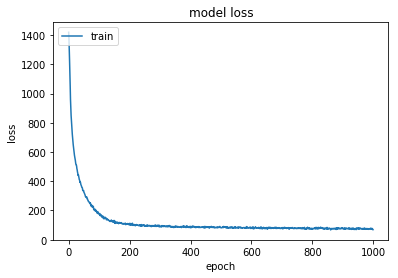

In [76]:
plt.plot(baseline_history.history['loss'])
#plt.plot(baseline_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[min, median, max] age: [6 25 88] years


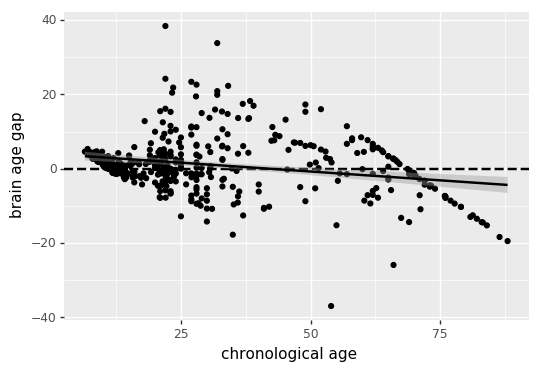

<ggplot: (7582322553)>


In [77]:
# bias shown in brain age gap: over/under-estimate for lower/upper ends
idx = np.argsort(Y_test)
age_gap = X_prediction - Y_test
dframe = pd.DataFrame()
dframe['age_gap'] = age_gap
dframe['Y_test'] = Y_test
p2 = ggplot(dframe, aes('Y_test','age_gap')) + geom_point() +\
    geom_hline(yintercept=[0], size=1, linetype='--') +\
    xlab('chronological age') +\
    ylab('brain age gap') +\
    stat_smooth(method='lm') 
  
print("[min, median, max] age: [%d %d %d] years" % (min(Y_test), np.median(Y_test), max(Y_test)))
print(p2) 

In [69]:
import pickle

In [78]:
with open('dnn.pickle', 'wb') as f:
    pickle.dump([Y_test, age_gap], f)